# Project 02 - Credit Card Classification
by Kevin Spurk

# 1 Executive Summary / Introdution

### Project description

You are working as a risk analyst with a bank. Apart from the other banking and loan services, the bank also provides credit card services which is a very important source of revenue for the bank. The bank wants to understand the demographics and other characteristics of its customers that accept a credit card offer and that do not accept a credit card. Usually the observational data for these kinds of problems is somewhat limited in that often the company sees only those who respond to an offer. To get around this, the bank designs a focused marketing study, with 18,000 current bank customers. This focused approach allows the bank to know who does and does not respond to the offer, and to use existing demographic data that is already available on each customer.

### Objective

The task is to build a model that will provide insight into why some bank customers accept credit card offers. There are also other potential areas of opportunities that the bank wants to understand from the data. Your senior management has also posted these other questions that will help them better understand their customers.

### Results

ToDo

# 2 Setup

### 2.1 Library imports

In [82]:
import pymysql
from sqlalchemy import create_engine
import getpass
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import chi2
from scipy.special import inv_boxcox
import pickle
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
import os
import math
import random
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.set_option('max_row', None)

In [2]:
password = getpass.getpass()

 ········


### 2.2 mySQL data import

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/credit_card_classification'
engine = create_engine(connection_string)

query = '''SELECT *
           FROM credit_card_data;
           '''

data = pd.read_sql_query(query, engine)

# 3 Data cleaning / wrangling

### 3.1 Overview

In [4]:
data.head()

,Customer_Number,Offer_Accepted,Reward,Mailer_Type,Income_Level,Bank_Accounts_Open,Overdraft_Protection,Credit_Rating,Credit_Cards_Held,#_Homes_Owned,Household_Size,Own_Your_Home,Average_Balance,Q1_Balance,Q2_Balance,Q3_Balance,Q4_Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095,1002
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78,366
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145,242
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119,419
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982,365


In [5]:
data.shape

(17976, 17)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17976 entries, 0 to 17975
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_Number       17976 non-null  int64  
 1   Offer_Accepted        17976 non-null  object 
 2   Reward                17976 non-null  object 
 3   Mailer_Type           17976 non-null  object 
 4   Income_Level          17976 non-null  object 
 5   Bank_Accounts_Open    17976 non-null  int64  
 6   Overdraft_Protection  17976 non-null  object 
 7   Credit_Rating         17976 non-null  object 
 8   Credit_Cards_Held     17976 non-null  int64  
 9   #_Homes_Owned         17976 non-null  int64  
 10  Household_Size        17976 non-null  int64  
 11  Own_Your_Home         17976 non-null  object 
 12  Average_Balance       17976 non-null  float64
 13  Q1_Balance            17976 non-null  int64  
 14  Q2_Balance            17976 non-null  int64  
 15  Q3_Balance         

> **Conclusion:** \n The dataframe includes **17976 customers**. The csv. file has data for 18000 customers. Due to an error in the data import of the csv. file into a mySQL database, there was a negligible loss of data. The customer data is stored in a total of **17 columns - 10 numerical and 7 categorical**. There are **no null values** present, but in a following step I'm checking im the data contains zeros that have to be dealt with.

### 3.2 Indexing

In [7]:
data.rename(columns={'Customer_Number':'id'}, inplace=True)
data = data.set_index('id')

### 3.3 Cleaning headers

In [8]:
columns_list = []
pattern = '#_'

for column in data.columns:
    column = re.sub(pattern, '', column)
    columns_list.append(column)

data.columns = columns_list

In [9]:
def clean_headers(df):
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
    return df

In [10]:
clean_headers(data)
data.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
id,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669,877,1095,1002
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39,106,78,366
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367,352,145,242
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578,1760,1119,419
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140,1357,982,365


### 3.4 Data cleaning

**Checking for negative values and unwanted zeros**

In [11]:
for column in data.select_dtypes(np.number):
    print(column, 'Negative values:', len(data[data[column] < 0]), 'Zeros:', len(data[data[column] == 0]), '\n')

bank_accounts_open Negative values: 0 Zeros: 0 

credit_cards_held Negative values: 0 Zeros: 0 

homes_owned Negative values: 0 Zeros: 0 

household_size Negative values: 0 Zeros: 0 

average_balance Negative values: 0 Zeros: 0 

q1_balance Negative values: 0 Zeros: 5 

q2_balance Negative values: 0 Zeros: 1 

q3_balance Negative values: 0 Zeros: 1 

q4_balance Negative values: 0 Zeros: 5 



>**Conclusion:** 

>Zeros in the balance columns are to be expected and don't have to be dealt with. There's no data cleaing to do.

# 4 EDA

### 4.1 Exploration of numerical features

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
bank_accounts_open,17976.0,1.255730,0.472405,1.00,1.00,1.0,1.00,3.00
credit_cards_held,17976.0,1.903427,0.797086,1.00,1.00,2.0,2.00,4.00
homes_owned,17976.0,1.203549,0.427446,1.00,1.00,1.0,1.00,3.00
household_size,17976.0,3.499110,1.114476,1.00,3.00,3.0,4.00,9.00
average_balance,17976.0,940.515562,350.297837,48.25,787.50,1007.0,1153.25,3366.25
q1_balance,17976.0,910.450656,620.077060,0.00,392.75,772.0,1521.00,3450.00
q2_balance,17976.0,999.392190,457.402268,0.00,663.00,1032.0,1342.00,3421.00
q3_balance,17976.0,1042.033600,553.452599,0.00,633.00,945.5,1463.00,3823.00
q4_balance,17976.0,810.185803,559.001365,0.00,363.00,703.0,1212.00,4215.00


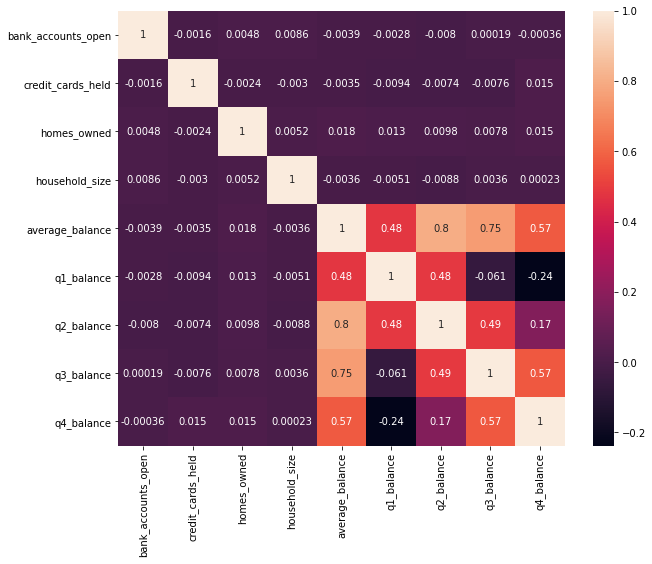

In [13]:
corr_matrix=data.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [14]:
def var_classification(df, bln, disc, skip_columns=[]):
    df_bln = df.copy()
    df_discrect = df.copy()
    df_cont = df.copy()
    
    for column in df.columns:
        if column not in skip_columns:
            if df[column].nunique() <= bln:
                df_bln[column] =  df_bln[column].astype('category')
                df_discrect = df_discrect.drop(column, axis=1)
                df_cont = df_cont.drop(column, axis=1)
            elif (df[column].nunique() > bln) & (df[column].nunique() < disc):
                df_bln = df_bln.drop(column, axis=1)
                df_cont = df_cont.drop(column, axis=1)
            else:
                df_bln = df_bln.drop(column, axis=1)
                df_discrect = df_discrect.drop(column, axis=1)
    return df_bln, df_discrect, df_cont

In [15]:
data_bln, data_discrete, data_cont = var_classification(data, bln=2, disc=10)


In [16]:
# function to display distribution plots and boxplots of columns in a df. 

def plots_continuous_var(df, skip_columns=[]):
    for column in df:
        if column not in skip_columns:
            custom_params = {"axes.spines.right": False, "axes.spines.top": False}
            sns.set_theme(style="ticks", rc=custom_params)
            fig, axes = plt.subplots(1, 2, figsize=(18, 5))
            sns.distplot(df[column], ax=axes[0])
            sns.boxplot(df[column], ax=axes[1])
            plt.show()

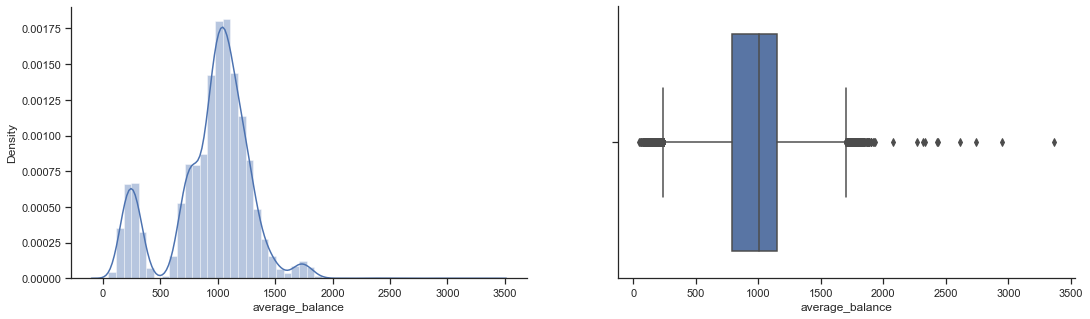

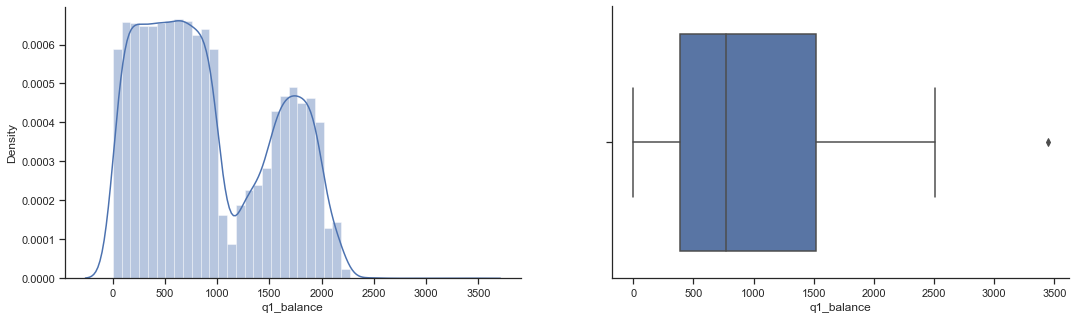

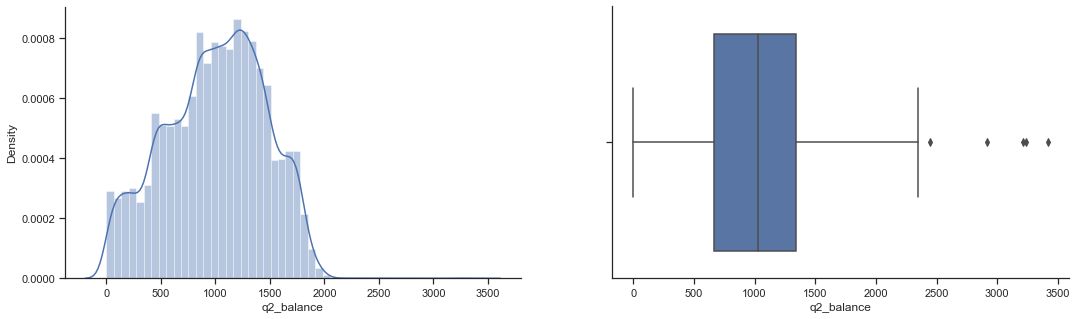

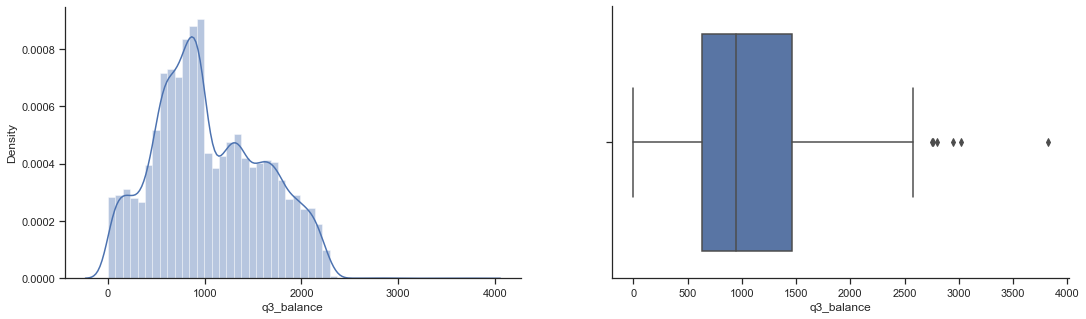

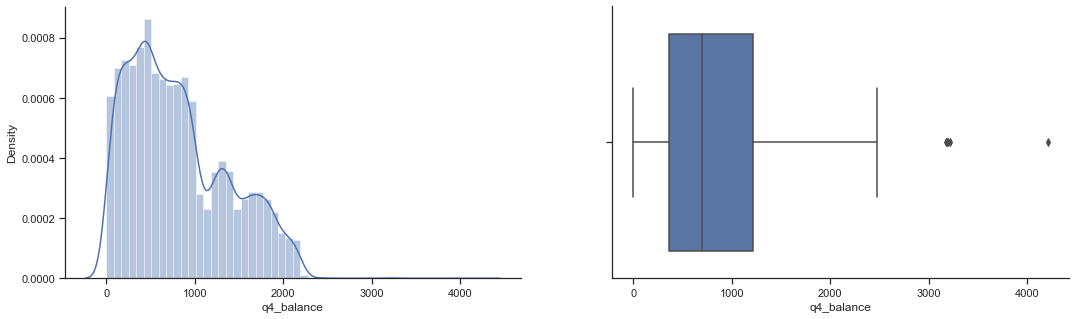

In [17]:
plots_continuous_var(data_cont)

### 4.2 Exploration of categorical features

**Value occurances**

In [18]:
for column in data.select_dtypes(np.object):
    print(column, data[column].value_counts(), '\n')

offer_accepted No     16955
Yes     1021
Name: offer_accepted, dtype: int64 

reward Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64 

mailer_type Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64 

income_level Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64 

overdraft_protection No     15300
Yes     2676
Name: overdraft_protection, dtype: int64 

credit_rating High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64 

own_your_home Yes    11636
No      6340
Name: own_your_home, dtype: int64 



### 4.3 Visual exploration of features with descrete values

In [19]:
# NOT WORKING

# function to display count plots and boxplots of columns in a df. 
'''
def plots_discrete_var(df, skip_columns=[]):
    for column in df:
        if column not in skip_columns:
            custom_params = {"axes.spines.right": False, "axes.spines.top": False}
            sns.set_theme(style="ticks", rc=custom_params)
            fig, axes = plt.subplots(1, 2, figsize=(18, 5))
            sns.countplot(x=df[column], ax=axes[0])
            sns.boxplot(x=df[column], ax=axes[1])
            plt.show()
'''

'\ndef plots_discrete_var(df, skip_columns=[]):\n    for column in df:\n        if column not in skip_columns:\n            custom_params = {"axes.spines.right": False, "axes.spines.top": False}\n            sns.set_theme(style="ticks", rc=custom_params)\n            fig, axes = plt.subplots(1, 2, figsize=(18, 5))\n            sns.countplot(x=df[column], ax=axes[0])\n            sns.boxplot(x=df[column], ax=axes[1])\n            plt.show()\n'

In [20]:
# plots_discrete_var(data_discrete)

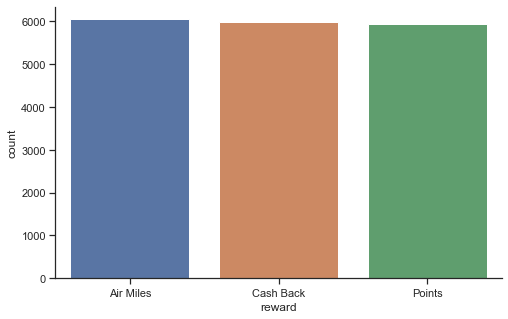

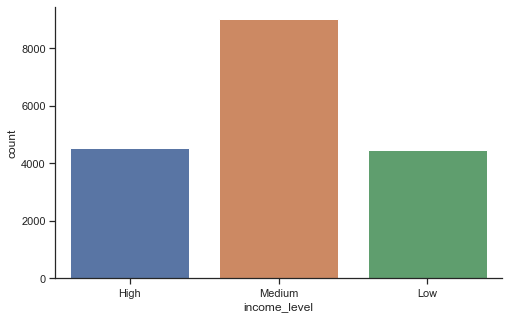

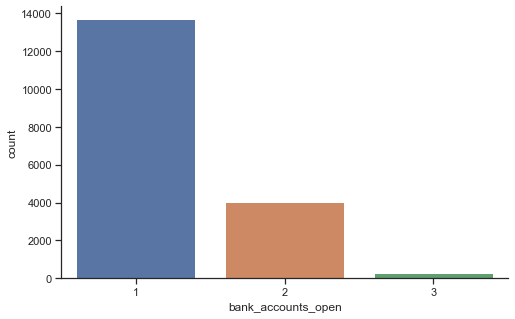

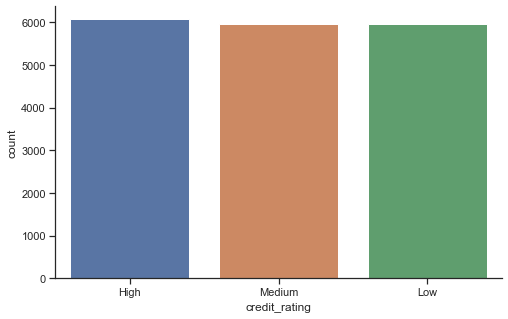

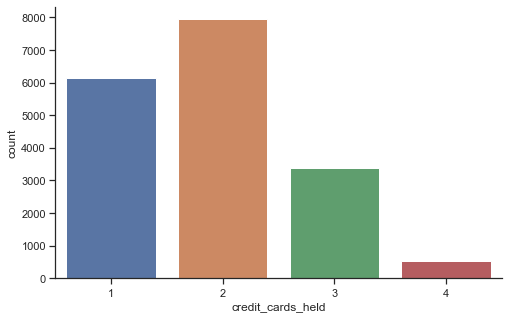

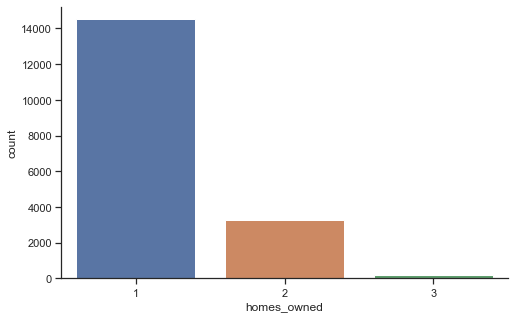

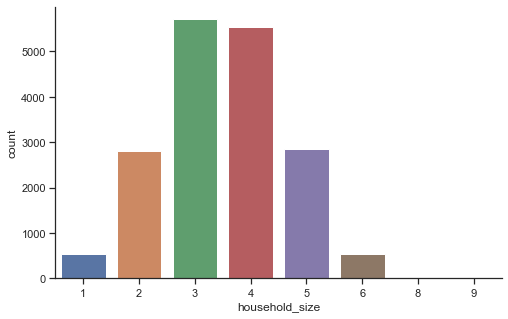

In [21]:
for column in data_discrete:
    plt.figure(figsize=(8,5))
    sns.countplot(x=data_discrete[column])
    plt.show()

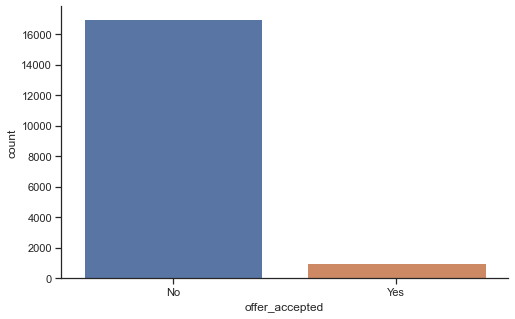

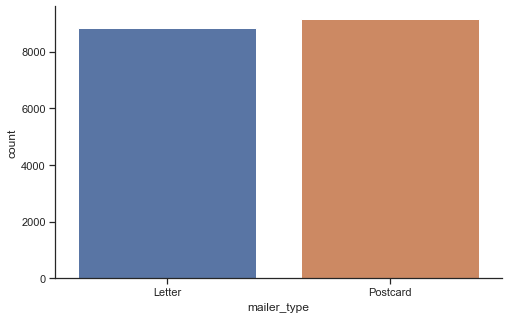

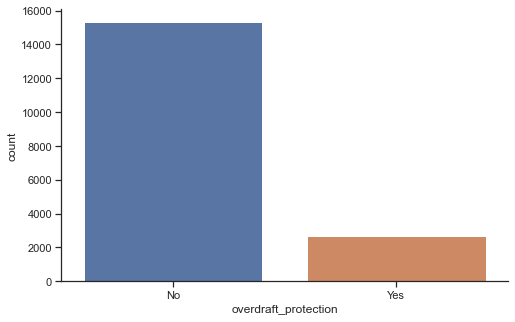

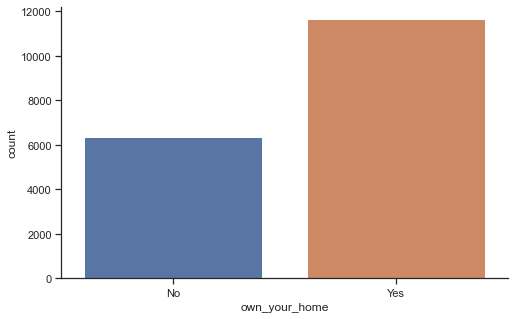

In [22]:
for column in data_bln:
    plt.figure(figsize=(8,5))
    sns.countplot(x=data_bln[column])
    plt.show()

# 5 Data processing

### 5.1 Feature selection

**Selection based on correlations**

The correlation matrix in step 4.1 didn't reveal any features that should neccessarily be dropped. The correlation of 'average_balance' with 'q2_balance' and 'q3_balance' is high (0.75 and 0.8) but I would only consider it a save drop with a value above 0.8. 

**Selection based on multicolinearity / Variance Inflation Factor (VIF)**

In [23]:
data_num = data.select_dtypes(np.number)

data_num.columns

Index(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance'],
      dtype='object')

In [24]:
features = "+".join(['bank_accounts_open', 'credit_cards_held', 'homes_owned', 'household_size', 'average_balance',
                     'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance'])

VIF_y, VIF_X = dmatrices('offer_accepted ~' + features, data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(VIF_X.values, i) for i in range(VIF_X.shape[1])]
vif["features"] = VIF_X.columns

vif.round(2).style.hide_index()

VIF Factor,features
38.270000,Intercept
1.000000,bank_accounts_open
1.000000,credit_cards_held
1.000000,homes_owned
1.000000,household_size
inf,average_balance
inf,q1_balance
inf,q2_balance
inf,q3_balance
inf,q4_balance


> **Conclusion:** ...

**Selection of categorical features / Chi2 Test**

- Description Chi2 Test
- Description function

In [25]:
# neccessary import: 'from scipy.stats import chi2'

def chi2_check(df, conf=95):
    # create dfs for chi2 calculated, diffrence between chi2 calculated and critical value, p-value
    df_chi2calc = pd.DataFrame(index=df.columns, columns=df.columns)
    df_chi2diff = pd.DataFrame(index=df.columns, columns=df.columns)
    df_p = pd.DataFrame(index=df.columns, columns=df.columns)
    
    # creste array with critical values of chi2 distribution
    p = np.array([0.05, 0.01, 0.001])
    deg_f = np.array(range(1, 31)).reshape(-1, 1)
    chi2_table = pd.DataFrame(chi2.isf(p, deg_f), columns=['95', '99', '99.9'])
    
    # fill dfs with values from chi2 tests
    for i in df.columns:
        for j in df.columns:
            if i != j:
                # chi2 calculated and p-value
                data_crosstab = pd.crosstab(data[i], data[j], margins = False)
                chi2_results = chi2_contingency(data_crosstab, correction=False)
                df_chi2calc[i].loc[j] = round(chi2_results[0],2)
                df_p[i].loc[j] = round(chi2_results[1],2)
                
                # diffrence between chi2 calculated and critical value
                table_dof = chi2_results[2] - 1
                for c in chi2_table.columns:
                    if float(c) == conf:
                        if chi2_results[2] < 30:
                            df_chi2diff[i].loc[j] = round((chi2_results[0] - chi2_table[c].loc[table_dof]), 2)
                        else:
                            df_chi2diff[i].loc[j] = round((chi2_results[0] - chi2_table[c].loc[29]), 2)
    
    # filling values along the df diagonals with '-'
    df_chi2calc = df_chi2calc.fillna('-')
    df_chi2diff = df_chi2diff.fillna('-')
    df_p = df_p.fillna('-')
    
    return df_chi2calc, df_chi2diff, df_p
                                 

In [26]:
data_cat = data.select_dtypes(np.object)

data_chi2calculated, data_chi2difference, data_chi2p = chi2_check(data_cat)

**Overview of calculated chi2 values**

In [27]:
data_chi2calculated

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
offer_accepted,-,101.15,169.88,113.62,0.13,445.06,0.0
reward,101.15,-,0.81,2.42,1.66,2.4,1.87
mailer_type,169.88,0.81,-,1.07,0.15,0.66,0.33
income_level,113.62,2.42,1.07,-,1.22,2.98,2.16
overdraft_protection,0.13,1.66,0.15,1.22,-,1.35,1.28
credit_rating,445.06,2.4,0.66,2.98,1.35,-,1.06
own_your_home,0.0,1.87,0.33,2.16,1.28,1.06,-


**Overview of diffences between calculated chi2 value and critical value**

In [28]:
data_chi2difference

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
offer_accepted,-,95.16,166.04,107.63,-3.71,439.07,-3.84
reward,95.16,-,-5.18,-7.07,-4.33,-7.09,-4.12
mailer_type,166.04,-5.18,-,-4.92,-3.69,-5.34,-3.51
income_level,107.63,-7.07,-4.92,-,-4.77,-6.51,-3.83
overdraft_protection,-3.71,-4.33,-3.69,-4.77,-,-4.64,-2.56
credit_rating,439.07,-7.09,-5.34,-6.51,-4.64,-,-4.93
own_your_home,-3.84,-4.12,-3.51,-3.83,-2.56,-4.93,-


**Overview of p values**

In [29]:
data_chi2p

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
offer_accepted,-,0.0,0.0,0.0,0.72,0.0,0.99
reward,0.0,-,0.67,0.66,0.44,0.66,0.39
mailer_type,0.0,0.67,-,0.59,0.7,0.72,0.56
income_level,0.0,0.66,0.59,-,0.54,0.56,0.34
overdraft_protection,0.72,0.44,0.7,0.54,-,0.51,0.26
credit_rating,0.0,0.66,0.72,0.56,0.51,-,0.59
own_your_home,0.99,0.39,0.56,0.34,0.26,0.59,-


> **Conclusions:**
    No drops - DETAILS

### 5.2 Feature engineering

**Numerical variables**

No changes until after baseline model

**Categorical variables (Encoding)**

In [30]:
# Get dummies encoding

data_dummies = data_cat.drop(['income_level', 'credit_rating', 'offer_accepted'], axis=1)
data_dummies = pd.get_dummies(data_dummies, drop_first=True)

data_dummies.head()

,reward_Cash Back,reward_Points,mailer_type_Postcard,overdraft_protection_Yes,own_your_home_Yes
id,,,,,
1,0,0,0,0,0
2,0,0,0,0,1
3,0,0,1,0,1
4,0,0,0,0,0
5,0,0,0,0,1


In [31]:
# ordinal encoding

data_ord = data_cat.drop(['offer_accepted', 'reward', 'mailer_type', 'overdraft_protection', 'own_your_home'], axis=1)

data_ord['income_level'] = data_ord['income_level'].map({'Low' : 1, 'Medium' : 2, 'High' : 3})
data_ord['credit_rating'] = data_ord['credit_rating'].map({'Low' : 1, 'Medium' : 2, 'High' : 3})

data_ord.head()

,income_level,credit_rating
id,,
1,3,3
2,2,2
3,3,2
4,2,3
5,2,2


# 6 Baseline model

### 6.1. x-y-split

In [32]:
data_X = pd.concat([data_num, data_dummies, data_ord], axis=1)
y = pd.DataFrame(data['offer_accepted'])

### 6.2 Solving Data imbalance

**Strategies**

In [33]:
y['offer_accepted'].value_counts()

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

Comparing different strategies to pick the best performance for baseline model. Not TomekLinks because it's only useful for smaller class imbalances.

- Downsamling
- Up-/Downsampling Mix
- SMOTE
- Class weighting



**Balancing and Classification**

In [89]:
# function to deal with class imbalances in binary classification
# requires import 'math', 'from imblearn.over_sampling import SMOTE', 'from sklearn.metrics import confusion_matrix', 'from sklearn.metrics import plot_confusion_matrix' 

def balanced_classification(x, y, method='down', ratio=1.5):
    
    # Train-Test-Split
    imb_X, test_X, imb_Y, test_Y = train_test_split(x, y, test_size=0.2, random_state=96)
    
    # values to navigate target variable
    target_col = list(imb_Y.columns.values)[0]
    values_sorted = imb_Y[target_col].value_counts()
    train_imbalanced = pd.concat([imb_X, imb_Y], axis=1)
    
    # the balanced training test has to be equal to the imbalanced in case method == weights
    bal_X = imb_X
    bal_Y = imb_Y
    
    # class weights set to 1 in case method != weights
    weights = {values_sorted.index[0]: 1, 
               values_sorted.index[1]: 1}
    
    # SMOTE
    if method == 'smo':
        smote = SMOTE()
        bal_X, bal_Y = smote.fit_resample(imb_X, imb_Y)
    
    # Class weighting
    elif method == 'wgx':
        total = sum(values_sorted)      
        weights = {values_sorted.index[0]: total/(2*ratio*values_sorted[0]), 
                   values_sorted.index[1]: total/(2*values_sorted[1])}
    
    else:    
        # Downsampling
        if method == 'down':
            sample_size = values_sorted[1]
            maj_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[0]].sample(round(sample_size*ratio))
            min_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[1]].sample(sample_size)
    
        # Upsampling    
        elif method == 'up':
            sample_size = values_sorted[0]
            maj_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[0]].sample(sample_size)
            min_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[1]].sample(round(sample_size/ratio), replace=True)

        # Mix Up-/Downsampling
        elif method == 'mix':
            sample_size = values_sorted[1]
            imbalance_factor = math.floor(values_sorted[0]/values_sorted[1])
            sample_factor = math.floor(imbalance_factor/3)
            maj_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[0]].sample(round(sample_size*sample_factor*ratio))
            min_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[1]].sample(round(sample_size*sample_factor), replace=True)
          
        train_sampled = pd.concat([maj_class, min_class]).sample(frac=1)
        # creating dfs of balanced classes to return
        bal_X = train_sampled.drop([target_col], axis=1)
        bal_Y = pd.DataFrame(train_sampled[target_col])

    # model execution
    classification_balanced = LogisticRegression(random_state=23, max_iter=1000, class_weight=weights)
    classification_balanced.fit(bal_X, bal_Y)
    
    # predictions and report
    predictions_balanced = classification_balanced.predict(test_X)
    report_balanced = pd.DataFrame(metrics.classification_report(test_Y, predictions_balanced, output_dict=True)).transpose()
    report_balanced = round(report_balanced, 3)
    
    # confusion matrix plot
    cf_matrix = confusion_matrix(test_Y, predictions_balanced)
    group1 = 'True ' + values_sorted.index[0]
    group2 = 'False ' + values_sorted.index[0]
    group3 = 'False ' + values_sorted.index[1]
    group4 = 'True ' + values_sorted.index[1]
    group_names = [group1, group2, group3, group4]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    cfnmx_plot = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    return bal_X, bal_Y, test_X, test_Y, classification_balanced, predictions_balanced, report_balanced, cfnmx_plot
    
    

**Model A1: Logistic Regression w/ Downsampling**

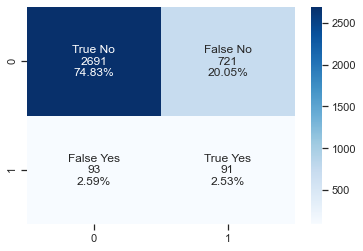

In [90]:
# NOT WORKING: Executing shows plot immediately

X1_train, Y1_train, X1_test, Y1_test, classification_1, predictions_1, report_1, confusionmatrix_1 = balanced_classification(x=data_X, y=y, method='down')

In [42]:
confusionmatrix_1

<AxesSubplot:>

In [91]:
report_1

,precision,recall,f1-score,support
No,0.967,0.789,0.869,3412.000
Yes,0.112,0.495,0.183,184.000
accuracy,0.774,0.774,0.774,0.774
macro avg,0.539,0.642,0.526,3596.000
weighted avg,0.923,0.774,0.834,3596.000


**Model A2: Logistic Regression w/ mixed sampling**

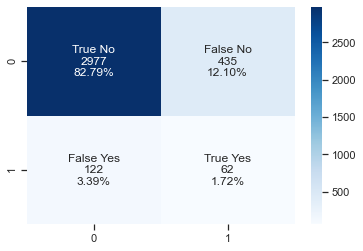

In [92]:
X2_train, Y2_train, X2_test, Y2_test, classification_2, predictions_2, report_2, confusionmatrix_2 = balanced_classification(x=data_X, y=y, method='mix', ratio=2)

In [93]:
report_2

,precision,recall,f1-score,support
No,0.961,0.873,0.914,3412.000
Yes,0.125,0.337,0.182,184.000
accuracy,0.845,0.845,0.845,0.845
macro avg,0.543,0.605,0.548,3596.000
weighted avg,0.918,0.845,0.877,3596.000


**Model A3: Logistic Regression w/ SMOTE**

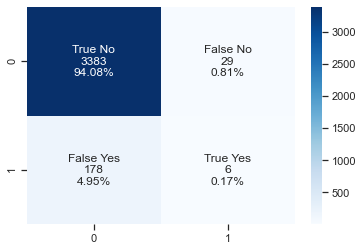

In [94]:
X3_train, Y3_train, X3_test, Y3_test, classification_3, predictions_3, report_3, confusionmatrix_3 = balanced_classification(x=data_X, y=y, method='smo')

In [95]:
report_3

,precision,recall,f1-score,support
No,0.950,0.992,0.970,3412.000
Yes,0.171,0.033,0.055,184.000
accuracy,0.942,0.942,0.942,0.942
macro avg,0.561,0.512,0.513,3596.000
weighted avg,0.910,0.942,0.923,3596.000


> **Conclusions:** Continue with model with best balance...

In [126]:
# function to zip n lists with equal number of elements into one 1-dimensional list

def zip_list(lists): 
    new_list = []
    for i in range(len(lists[0])):
        for l in lists:
            new_list.append(l[i])
    return new_list

# takes a list of names for models and a list of classification reports as input

def classifier_comparison(modelnames, reports):
    comparison_df = pd.DataFrame()
    # lists for comparison df
    accuracy_scores = []
    model_count = 0
    skip_list = []
    
    # get values from reports into comparison df
    for classifier_report in reports:
        accuracy_scores.append(classifier_report['precision'].iloc[2])
        comparison_df = pd.concat([comparison_df, classifier_report[0:2]])
        skip_list.append('')
        
    modelnames_filled = zip_list([modelnames, skip_list])
    accuracy_scores_filled = zip_list([accuracy_scores, skip_list])
    comparison_df['model_name'] = modelnames_filled
    comparison_df['accuracy'] = accuracy_scores_filled
    comparison_df['class'] = comparison_df.index
    
    # format comparison df
    comparison_df = comparison_df.set_index('model_name')
    comparison_df = comparison_df[['accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    
    return comparison_df
    

In [127]:
names_balanced_models = ['A1: Linear Regression w/ downsampling','A2: Linear Regression w/ mixed sampling', 'A3: Linear Regression w/ SMOTE']
reports_balanced_models = [report_1, report_2, report_3]

balanced_classes_test = classifier_comparison(modelnames=names_balanced_models, reports=reports_balanced_models)
balanced_classes_test

,accuracy,class,precision,recall,f1-score,support
model_name,,,,,,
A1: Linear Regression w/ downsampling,0.774,No,0.967,0.789,0.869,3412.0
,,Yes,0.112,0.495,0.183,184.0
A2: Linear Regression w/ mixed sampling,0.845,No,0.961,0.873,0.914,3412.0
,,Yes,0.125,0.337,0.182,184.0
A3: Linear Regression w/ SMOTE,0.942,No,0.950,0.992,0.970,3412.0
,,Yes,0.171,0.033,0.055,184.0


# 7 model building

### 7.1 Model builing approach

Building different models ancomparing them in next step. List:

- Logistic Regression with different thresholds
- KNN Regressor with k parameter tuning
- Logistic Regression with transformed data
- Logistic Regression with scaled data
- Logistic Regression with transformed and scaled data
- KNN Regressor with transformed data
- KNN Regressor with scaled data
- KNN Regressor with transformed and scaled data
- ...

### 7.2 Model functions

In [133]:
def classification_generator(model, X_train, y_train, X_test, y_test, k=3, weight_ratio=1):
    # values to navigate target variable
    target_col = list(y_train.columns.values)[0]
    values_sorted = y_train[target_col].value_counts()

    # model execution  
    if model == 'LR':
        # Class weighting
        if class_ratio == 1:
            weights = {values_sorted.index[0]: 1, 
                       values_sorted.index[1]: 1}
        else:
            total = sum(values_sorted)      
            weights = {values_sorted.index[0]: total/(2*weight_ratio*values_sorted[0]), 
                       values_sorted.index[1]: total/(2*values_sorted[1])}
        
        classification = LogisticRegression(random_state=23, max_iter=1000, class_weight=weights)
    
    elif model == 'KNC':
        classification = KNeighborsClassifier(n_neighbors=k)
        
    elif model == 'GP':
        classification = GaussianProcessClassifier(1.0 * RBF(1.0))
        
    elif model == 'DT':
        classification = DecisionTreeClassifier(max_depth=5)
        
    elif model == 'RF':
        classification = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    
    elif model == 'MLP':
        classification = MLPClassifier(alpha=1, max_iter=1000)
        
    elif model == 'ADA':
        classification = AdaBoostClassifier()
        
    elif model == 'NB':
        classification = GaussianNB()
        
    classification.fit(X_train, y_train)
    
    # predictions and report
    predictions = classification.predict(X_test)
    report = pd.DataFrame(metrics.classification_report(y_test, predictions, output_dict=True)).transpose()
    
    # confusion matrix plot
    cf_matrix = confusion_matrix(y_test, predictions)
    group1 = 'True ' + values_sorted.index[0]
    group2 = 'False ' + values_sorted.index[0]
    group3 = 'False ' + values_sorted.index[1]
    group4 = 'True ' + values_sorted.index[1]
    group_names = [group1, group2, group3, group4]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    cfnmx_plot = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    return classification, predictions, report, cfnmx_plot

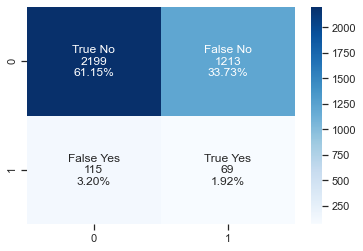

In [134]:
knn3, knn3_predictions, knn3_report, knn3_plot = classification_generator(model='KNC', X_train=X1_train, y_train=Y1_train, X_test=X1_test, y_test=Y1_test)

In [135]:
knn3_report

,precision,recall,f1-score,support
No,0.950303,0.644490,0.768075,3412.000000
Yes,0.053822,0.375000,0.094134,184.000000
accuracy,0.630701,0.630701,0.630701,0.630701
macro avg,0.502062,0.509745,0.431105,3596.000000
weighted avg,0.904431,0.630701,0.733591,3596.000000


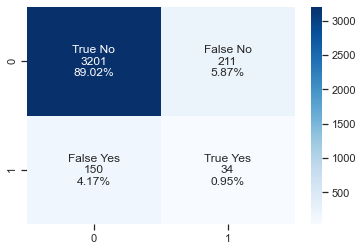

In [84]:
rf1, rf1_predictions, rf1_report, rf1_plot = classification_generator(model='RF', X_train=X1_train, y_train=Y1_train, X_test=X1_test, y_test=Y1_test)

In [144]:
# KNN with multiple k values

def knc_generator(X_train, y_train, X_test, y_test, k_min=2, k_max=10):
    comparison_df = pd.DataFrame()
    knc_scores = []
    
    for k in range(2, k_max):
        # model execution
        classification = KNeighborsClassifier(n_neighbors=k)
        classification.fit(X_train, y_train)
        
        # predictions and report
        predictions = classification.predict(X_test)
        report = pd.DataFrame(metrics.classification_report(y_test, predictions, output_dict=True)).transpose()
        score = classification.score(X_test, y_test)
        knc_scores.append(score)
        
        # transform knc report for comparison df
        report = round(report[0:2], 3)
        
        # create new columns for comparison df
        model_name = 'KNC with k = ' + str(k)
        name_col = [model_name, '']
        report['model_name'] = name_col
        report['class'] = report.index
        report['accuracy'] = [round(score, 3), '']
        # concat df from current iteration with previous dfs
        comparison_df = pd.concat([comparison_df, report])
        
    # format comparison df
    comparison_df = comparison_df.set_index('model_name')
    comparison_df = comparison_df[['accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    
    # plot k value vs. r2
    plt.figure(figsize=(10,6))
    plt.plot(range(2, k_max),knc_scores,color = 'blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.title('accuracy scores vs. k value')
    plt.xlabel('K')
    plt.ylabel('Accuracy score')
            
    return comparison_df

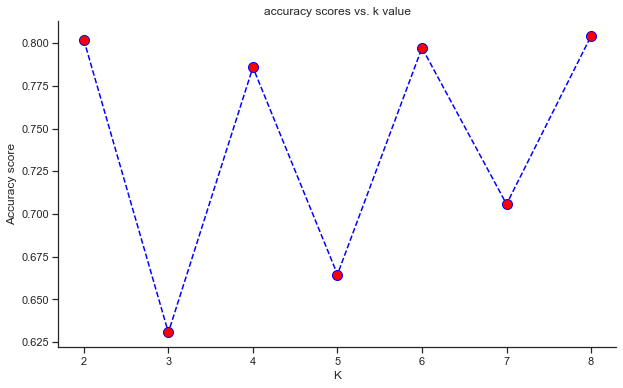

In [142]:
knc_comparison = knc_generator(X_train=X1_train, y_train=Y1_train, X_test=X1_test, y_test=Y1_test, k_max=9)

In [143]:
knc_comparison

,accuracy,class,precision,recall,f1-score,support
model_name,,,,,,
KNC with k =2,0.802,No,0.948,0.837,0.889,3412.0
,,Yes,0.046,0.147,0.070,184.0
KNC with k =3,0.631,No,0.950,0.644,0.768,3412.0
,,Yes,0.054,0.375,0.094,184.0
KNC with k =4,0.786,No,0.948,0.819,0.879,3412.0
,,Yes,0.049,0.174,0.077,184.0
KNC with k =5,0.665,No,0.948,0.684,0.795,3412.0
,,Yes,0.049,0.299,0.084,184.0
KNC with k =6,0.797,No,0.949,0.831,0.886,3412.0


### 7.2 Logistic Regression with thresholds parameter tuning

### 7.3 KNN Regressor with k parameter tuning (different thresholds ?)

other models

models with transformed var

models with scaled variables

models with combined improvements

In [ ]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(12, 10)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [ ]:
plot_multiclass_roc(classification_1, X1_test, Y1_test, n_classes=2)

In [ ]:
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')

# 8 Model comparison